## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import hashlib
import os
import pickle
from urllib.request import urlretrieve
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile
import cv2
from matplotlib import gridspec
import math
import tensorflow as tf
import random
from random import sample
import math
from tensorflow.contrib.layers import flatten
import time
import datetime
from datetime import timedelta
from sklearn.metrics import confusion_matrix

## Load Data

Load the German Traffic Signs data.

In [3]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

## Data Dimensions

In [4]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: number of training examples
n_train_label = len(y_train)

# TODO: number of testing examples
n_test_label = len(y_test)

# TODO: what's the shape of an image?
train_image_shape = X_train.shape
test_image_shape = X_test.shape
train_label_shape = y_train.shape
test_label_shape = y_test.shape

#print("X_train = ", X_train[0])

# TODO: how many classes are in the dataset
n_classes = max(y_train) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of training labels =", n_train_label)
print("Number of testing labels =", n_test_label)
print("Training image data shape =", train_image_shape)
print("Testing image data shape =", test_image_shape)
print("Training label data shape =", train_label_shape)
print("Testing label data shape =", test_label_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Number of training labels = 39209
Number of testing labels = 12630
Training image data shape = (39209, 32, 32, 3)
Testing image data shape = (12630, 32, 32, 3)
Training label data shape = (39209,)
Testing label data shape = (12630,)
Number of classes = 43


## Helper Functions to Process Data

### Function to Convert to Grayscale

In [5]:
### Covert to grayscale
def convert_to_grayscale():
    X_gray_train = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in X_train])
    return(X_gray_train)

### Function to Normalize the Image Data

In [6]:
### Normalize
def normalize_grayscale(image_data):
    normed_image = cv2.normalize(image_data, None, 0.0, 1.1, cv2.NORM_MINMAX, cv2.CV_32F)
    
    return(normed_image)

### Function for One Hot Encoding

In [7]:
def One_Hot_Encode():
    # Turn labels into numbers and apply One-Hot Encoding
    encoder = LabelBinarizer()
    encoder.fit(y_train) # fitting the encoder on training labels
    train_labels = encoder.transform(y_train)
    test_labels = encoder.transform(y_test)

    # Change to float32, so it can be multiplied against the features in 
    # TensorFlow, which are float32
    hot_train_labels = train_labels.astype(np.float32)
    hot_test_labels = test_labels.astype(np.float32)
    
    is_labels_encod = True
    return hot_train_labels, hot_test_labels
    

### Function to Divide Function into Batches

In [62]:
### Use this function create batches
def batches(X, y, batch_size):
    # Number of batches includes a final "rest" batch
    # if division is not exact    
    n = int(math.ceil(len(X) / batch_size))
    for k in sample(range(n), n): # Output batches in random order
        a = k * batch_size
        b = a + batch_size
        #yield (k, X[a:b], y[a:b])
        return X[a:b], y[a:b]

### Carry Out All Data Processing

In [63]:
### Convert the images to grayscale
X_gray_train = convert_to_grayscale()

### Display the grayscaled images
#display_grid(X_gray_train, 5, 43)

### Normzlize the grayscaled images
norm_image = normalize_grayscale(X_gray_train)
norm_image = np.array([normalize_grayscale(image) for image in X_gray_train], dtype=np.float32)

### Generate OHE
hot_train_labels, hot_test_labels = One_Hot_Encode()

### Display the normalized grayscaled images
#display_grid(norm_image, 5, 43)

### Divide Training Data into Training and Validation Data

In [11]:
# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    norm_image,
    y_train,
    test_size=0.05,
    random_state=832289)

test_features = X_test
test_labels = y_test

### Helper-function for flattening a layer

In [12]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [13]:
### Plot the input images ###
def plot_input_images():
    sample_size = 5 #five images per class label
    count = 1 #book keeping for plots
    fig = plt.figure(figsize=(30, 30))

    for i in range(n_classes):
        ind = y_train == i
        subset_x = X_train[ind,] #get all images that belong to class i

        for x in range(sample_size):
            img = random.choice(subset_x) #randomly pick on image from class i
            
    
### Display the images in the form of a grid
def display_grid(image_data, sample_size, n_labels):
    count = 0 #book keeping for plots
    
    fig = plt.figure(figsize=(sample_size, n_labels))

    grid = gridspec.GridSpec(n_labels, sample_size, wspace=0.0, hspace=0.0)
    labelset_pbar = tqdm(range(n_labels), desc='Sample test images', unit='labels')

    for k in labelset_pbar:
        ind = y_train == k
        subset = image_data[ind,] #get all images that belong to class k
        
        for x in range(sample_size):
            img = random.choice(subset) #randomly pick on image from class k
            ax = plt.Subplot(fig, grid[count])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(img) #, cmap='gray')
            fig.add_subplot(ax)
            count +=1

    # hide the borders
    if k == (n_labels-1):
        all_axes = fig.get_axes()

    for ax in all_axes:
        for sp in ax.spines.values():
            sp.set_visible(False)
            plt.show()
            
##################################################################################################3
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i], cmap='binary')
    
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
    
        # Show the classes as the label on the x-axis.,
        ax.set_xlabel(xlabel)
       
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.\
    plt.show()

### Plot a few images to see if data is correct

In [14]:
### Display the grayscaled images
#display_grid(X_gray_train, 5, 43)

### Display the normalized grayscaled images
#display_grid(norm_image, 5, 43)


## Configuration of Neural Network

The configuration of the Convolutional Neural Network is defined here for convenience, so you can easily find and change these numbers and re-run the Notebook.

In [15]:
# Layer-1 - Convolutional Layer 1.
filter_size1 = 7          # Convolution filters are 7 x 7 pixels.
num_filters1 = 100        # There are 100 of these filters.

# Layer-2 - Max Pooling Layer 1.
max_pool_size = 2

# Layer-3 - Convolutional Layer 2.
filter_size2 = 4          # Convolution filters are 4 x 4 pixels.
num_filters2 = 150        # There are 150 of these filters.

# Layer-4 - Max Pooling Layer 2
max_pool_size = 2

# Layer-5 - Convolutional Layer 3.
filter_size3 = 4          # Convolution filters are 4 x 4 pixels.
num_filters3 = 250        # There are 250 of these filters.

# Layer-6 - Max Pooling Layer 3
max_pool_size = 2

# Layer-7 - Fully-connected layer 1.
fc_size1 = 300             # Number of neurons in fully-connected layer.

# Layer-8 - Fully-connected layer 2.
fc_size2 = 43              # Number of neurons in fully-connected layer.



The data dimensions are used in several places in the source-code below. They are defined once so we can use these variables instead of numbers throughout the source-code below.

In [25]:
# We know that images are 32 pixels in each dimension.
img_size = 32

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 43 classes
num_classes = 43

## TensorFlow Graph

### Helper-functions for creating new variables

Functions for creating new TensorFlow variables in the given shape and initializing them with random values. Note that the initialization is not actually done at this point, it is merely being defined in the TensorFlow graph.

In [26]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [27]:
def new_biases(length):
    return tf.Variable(tf.zeros(shape=[length]))

### Helper-function for creating a new Convolutional Layer

In [28]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    layer = tf.nn.relu(layer)

    return layer, weights

### Helper-function for creating a new Fully-Connected Layer

In [29]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### Placeholder variables

In [30]:
x = tf.placeholder(np.float32, shape=[None, img_size_flat], name='x')

The convolutional layers expect `x` to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead `[num_images, img_height, img_width, num_channels]`. Note that `img_height == img_width == img_size` and `num_images` can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

In [31]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable `x`. The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of labels and each label is a vector of length `num_classes` which is 10 in this case.

In [32]:
y_true = tf.placeholder(tf.float32, shape=[None, 43], name='y_true')

We could also have a placeholder variable for the class-number, but we will instead calculate it using argmax. Note that this is a TensorFlow operator so nothing is calculated at this point.

In [33]:
y_true_cls = tf.argmax(y_true, dimension=1)

### Convolutional Layer 1

In [34]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [35]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 16, 16, 100) dtype=float32>

### Convolutional Layer 2

In [36]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [37]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 8, 8, 150) dtype=float32>

### Convolutional Layer 3

In [38]:
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)

In [39]:
layer_conv3

<tf.Tensor 'Relu_2:0' shape=(?, 4, 4, 250) dtype=float32>

### Flatten Layer

In [40]:
layer_flat, num_features = flatten_layer(layer_conv3)

In [41]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 4000) dtype=float32>

In [42]:
num_features

4000

### Fully-Connected Layer 1

In [43]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size1,
                         use_relu=True)

In [44]:
layer_fc1

<tf.Tensor 'Relu_3:0' shape=(?, 300) dtype=float32>

### Fully-Connected Layer 2

In [45]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size1,
                         num_outputs=num_classes,
                         use_relu=False)

In [46]:
layer_fc2

<tf.Tensor 'add_4:0' shape=(?, 43) dtype=float32>

### Predicted Class

In [47]:
y_pred = tf.nn.softmax(layer_fc2)

The class-number is the index of the largest element.

In [48]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

### Cost-function to be optimized

In [49]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

In [50]:
cost = tf.reduce_mean(cross_entropy)

### Optimization Method

In [51]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### Performance Measures

In [52]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [53]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Create TensorFlow session

In [54]:
session = tf.Session()

### Initialize variables

In [55]:
session.run(tf.initialize_all_variables())

### Helper-function to perform optimization iterations

In [56]:
train_batch_size = 64

In [57]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = batches(X_gray_train, hot_train_labels, train_batch_size)
        
        x_batch_flat = np.reshape(x_batch, [-1, 1024])
        x_batch_flat = x_batch_flat.astype(np.float32)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch_flat,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations
    
    print("total_iterations = ", total_iterations)

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-function to plot example errors

In [58]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    #images = data.test.images[incorrect]
    images = X_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    #cls_true = data.test.cls[incorrect]
    cls_true = y_test[incorrect]
    #print("y_test[incorrect] = ", y_test[incorrect])
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot confusion matrix

In [59]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    #cls_true = data.test.cls
    cls_true = y_test
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for showing the performance

In [60]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = n_test

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        #images = data.test.images[i:j, :]
        X_test_flat = np.reshape(X_test, [-1, 1024])
        #print("X_test_flat = ", X_test_flat)
        
        images = X_test_flat[i:j, :]
        images = images.astype(np.float32)
        labels = hot_train_labels[i:j]
        
        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    #cls_true = data.test.cls
    cls_true = y_test
    
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)
    
    # Calculate the number of correctly classified images.
    correct_sum = np.sum(correct)

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test
    
    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Performance before any optimization

In [61]:
print_test_accuracy()

Accuracy on Test-Set: 3.2% (409 / 12630)


## Performance after 1 optimization iteration

In [64]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  31.2%
total_iterations =  1
Time usage: 0:00:04


In [65]:
print_test_accuracy()

Accuracy on Test-Set: 2.0% (253 / 12630)


## Performance after 100 optimization iterations

After 100 optimization iterations, the model has significantly improved its classification accuracy.

In [196]:
optimize(num_iterations=99) # We already performed 1 iteration above.

total_iterations =  100
Time usage: 0:03:22


Accuracy on Test-Set: 5.7% (716 / 12630)
Example errors:


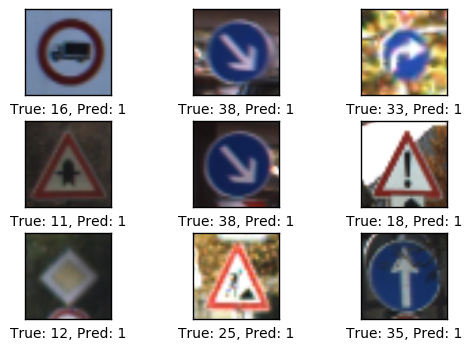

In [197]:
print_test_accuracy(show_example_errors=True)

## Performance after 1000 optimization iterations

After 1000 optimization iterations, the model has greatly increased its accuracy on the test-set to more than 90%.

In [79]:
optimize(num_iterations=900) # We performed 100 iterations above.

Optimization Iteration:    101, Training Accuracy:   0.0%
Optimization Iteration:    201, Training Accuracy:   0.0%
Optimization Iteration:    301, Training Accuracy:   0.0%
Optimization Iteration:    401, Training Accuracy:   3.1%
Optimization Iteration:    501, Training Accuracy:   0.0%
Optimization Iteration:    601, Training Accuracy:   0.0%
Optimization Iteration:    701, Training Accuracy:   0.0%
Optimization Iteration:    801, Training Accuracy:   7.8%
Optimization Iteration:    901, Training Accuracy:  25.0%
Time usage: 0:30:57


Accuracy on Test-Set: 4.5% (574 / 12630)
Example errors:


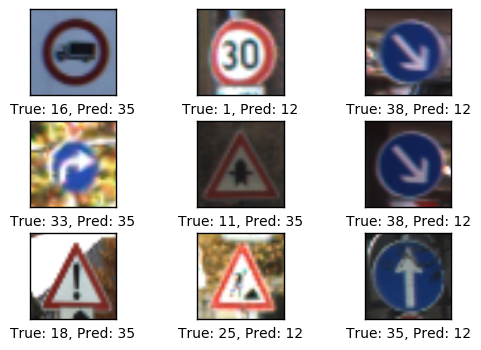

In [80]:
print_test_accuracy(show_example_errors=True)

## Performance after 10,000 optimization iterations

After 10,000 optimization iterations, the model has a classification accuracy on the test-set of about 99%.

In [81]:
optimize(num_iterations=9000) # We performed 1000 iterations above.

Optimization Iteration:   1001, Training Accuracy:  93.8%
Optimization Iteration:   1101, Training Accuracy:   0.0%
Optimization Iteration:   1201, Training Accuracy:   0.0%
Optimization Iteration:   1301, Training Accuracy:   0.0%
Optimization Iteration:   1401, Training Accuracy:   0.0%
Optimization Iteration:   1501, Training Accuracy:   0.0%
Optimization Iteration:   1601, Training Accuracy:   0.0%
Optimization Iteration:   1701, Training Accuracy: 100.0%
Optimization Iteration:   1801, Training Accuracy:   0.0%
Optimization Iteration:   1901, Training Accuracy:  96.9%
Optimization Iteration:   2001, Training Accuracy:  92.2%
Optimization Iteration:   2101, Training Accuracy:  42.2%
Optimization Iteration:   2201, Training Accuracy:  68.8%
Optimization Iteration:   2301, Training Accuracy:  89.1%
Optimization Iteration:   2401, Training Accuracy:   0.0%
Optimization Iteration:   2501, Training Accuracy:   0.0%
Optimization Iteration:   2601, Training Accuracy:   0.0%
Optimization I

Accuracy on Test-Set: 3.6% (460 / 12630)
Example errors:


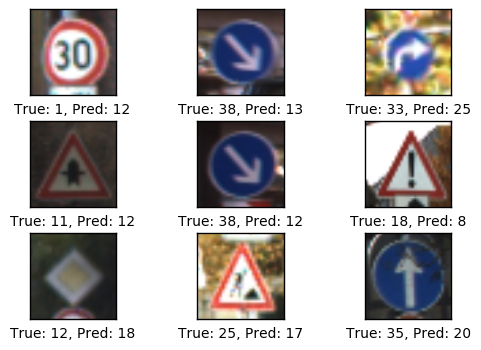

Confusion Matrix:
[[ 0  2  0 ...,  1  0  1]
 [ 0 15  5 ...,  2  0  1]
 [ 0 18  9 ...,  3  6  1]
 ..., 
 [ 0  1  1 ...,  0  0  0]
 [ 0  0  3 ...,  0  1  0]
 [ 0  4  3 ...,  1  0  0]]


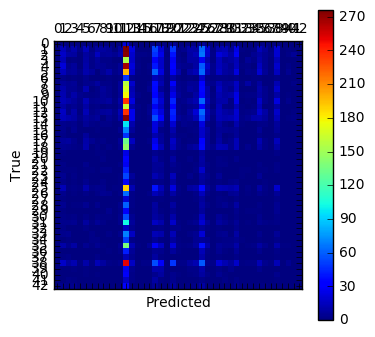

In [82]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Visualization of Weights and Layers

In trying to understand why the convolutional neural network can recognize handwritten digits, we will now visualize the weights of the convolutional filters and the resulting output images.

### Helper-function for plotting convolutional weights

In [83]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for plotting the output of a convolutional layer

In [84]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    image = image.reshape(-1, 1074)
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Input Images

Helper-function for plotting an image.

In [85]:
def plot_image(image):
    '''plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')'''
    plt.imshow(image,
               interpolation='nearest',
               cmap='binary')

    plt.show()

Plot an image from the test-set which will be used as an example below.

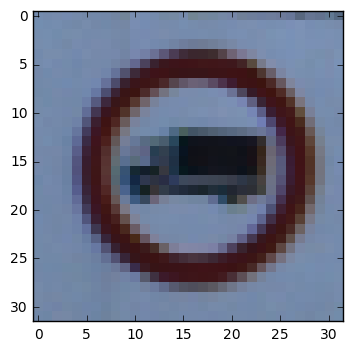

In [86]:
#image1 = data.test.images[0]
image1 = X_test[0]
plot_image(image1)

Plot another example image from the test-set.

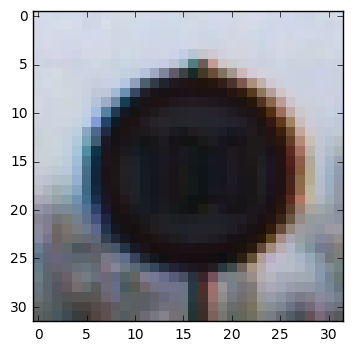

In [87]:
image2 = X_test[13]
plot_image(image2)

### Convolution Layer 1

Now plot the filter-weights for the first convolutional layer.

Note that positive weights are red and negative weights are blue.

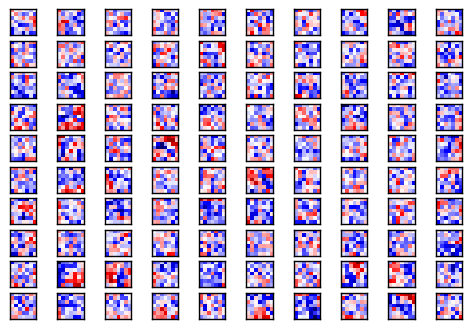

In [88]:
plot_conv_weights(weights=weights_conv1)

Applying each of these convolutional filters to the first input image gives the following output images, which are then used as input to the second convolutional layer. Note that these images are down-sampled to 16 x 16 pixels which is half the resolution of the original input image.

In [89]:
plot_conv_layer(layer=layer_conv1, image=image1)

ValueError: total size of new array must be unchanged

The following images are the results of applying the convolutional filters to the second image.

In [ ]:
plot_conv_layer(layer=layer_conv1, image=image2)

It is difficult to see from these images what the purpose of the convolutional filters might be. It appears that they have merely created several variations of the input image, as if light was shining from different angles and casting shadows in the image.

### Convolution Layer 2

Now plot the filter-weights for the second convolutional layer.

There are 16 output channels from the first conv-layer, which means there are 16 input channels to the second conv-layer. The second conv-layer has a set of filter-weights for each of its input channels. We start by plotting the filter-weigths for the first channel.

Note again that positive weights are red and negative weights are blue.

In [ ]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

There are 16 input channels to the second convolutional layer, so we can make another 15 plots of filter-weights like this. We just make one more with the filter-weights for the second channel. 

In [ ]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

It can be difficult to understand and keep track of how these filters are applied because of the high dimensionality.

Applying these convolutional filters to the images that were ouput from the first conv-layer gives the following images.

Note that these are down-sampled yet again to 7 x 7 pixels which is half the resolution of the images from the first conv-layer.

In [ ]:
plot_conv_layer(layer=layer_conv2, image=image1)

And these are the results of applying the filter-weights to the second image.

In [ ]:
plot_conv_layer(layer=layer_conv2, image=image2)

From these images, it looks like the second convolutional layer might detect lines and patterns in the input images, which are less sensitive to local variations in the original input images.

These images are then flattened and input to the fully-connected layer, but that is not shown here.

### Close TensorFlow Session

We are now done using TensorFlow, so we close the session to release its resources.

In [ ]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

## Conclusion

We have seen that a Convolutional Neural Network works much better at recognizing hand-written digits than the simple linear model in Tutorial #01. The Convolutional Network gets a classification accuracy of about 99%, or even more if you make some adjustments, compared to only 91% for the simple linear model.

However, the Convolutional Network is also much more complicated to implement, and it is not obvious from looking at the filter-weights why it works and why it sometimes fails.

So we would like an easier way to program Convolutional Neural Networks and we would also like a better way of visualizing their inner workings.

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Do you get the exact same results if you run the Notebook multiple times without changing any parameters? What are the sources of randomness?
* Run another 10,000 optimization iterations. Are the results better?
* Change the learning-rate for the optimizer.
* Change the configuration of the layers, such as the number of convolutional filters, the size of those filters, the number of neurons in the fully-connected layer, etc.
* Add a so-called drop-out layer after the fully-connected layer. Note that the drop-out probability should be zero when calculating the classification accuracy, so you will need a placeholder variable for this probability.
* Change the order of ReLU and max-pooling in the convolutional layer. Does it calculate the same thing? What is the fastest way of computing it? How many calculations are saved? Does it also work for Sigmoid-functions and average-pooling?
* Add one or more convolutional and fully-connected layers. Does it help performance?
* What is the smallest possible configuration that still gives good results?
* Try using ReLU in the last fully-connected layer. Does the performance change? Why?
* Try not using pooling in the convolutional layers. Does it change the classification accuracy and training time?
* Try using a 2x2 stride in the convolution instead of max-pooling? What is the difference?
* Remake the program yourself without looking too much at this source-code.
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.